In [133]:
import pandas as pd 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [134]:
df = pd.read_csv('https://raw.githubusercontent.com/annwanginnt/AI2/main/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/annwanginnt/AI2/main/test.csv', na_values=['', 'NULL', 'NaN'])

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Data Cleaning

### Deal with Null values

In [136]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [137]:
# Categorical data for those 'NA' has real meanings
na_columns_with_meaning = {
    'Alley': 'NoAlleyAccess',
    'MasVnrType' : 'NoMas',
    'BsmtQual': 'NoBasement',
    'BsmtCond': 'NoBasement',
    'BsmtExposure': 'NoBasement',
    'BsmtFinType1': 'NoBasement',
    'BsmtFinType2': 'NoBasement',
    'FireplaceQu': 'NoFireplace',
    'GarageType': 'NoGarage',
    'GarageFinish': 'NoGarage',
    'GarageQual': 'NoGarage',
    'GarageCond': 'NoGarage',
    'PoolQC': 'NoPool',
    'Fence': 'NoFence',
    'MiscFeature': 'None'
}

for column, fill_value in na_columns_with_meaning.items():
    df[column] = df[column].fillna(fill_value)

# fill in numberical missing value with average value
numeric_columns_with_nulls = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
for column in numeric_columns_with_nulls:
    df[column] = df[column].fillna(df[column].median())

# fill in with the most often value for column 'Electrical'
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

# check missing value again
missing_values_2 = df.isnull().sum()
missing_values_2[missing_values > 0]




LotFrontage     0
Alley           0
MasVnrType      0
MasVnrArea      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

# EDA

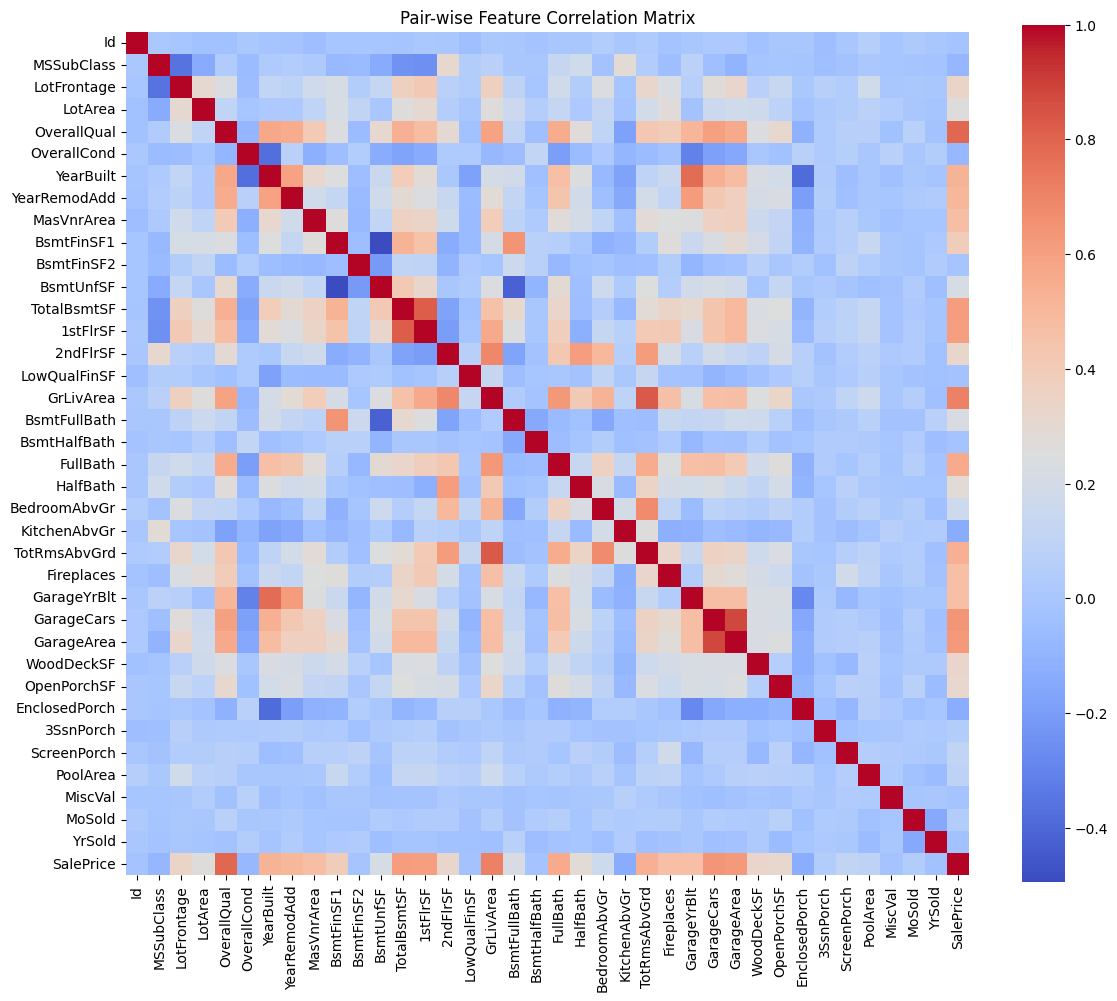

In [138]:

# Select only numerical columns for correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Pair-wise Feature Correlation Matrix')
plt.tight_layout()
plt.show()



## Feature Engineering

In [139]:
# Onehot encode categorical data
df_encoded = pd.get_dummies(df, drop_first=True)


In [140]:
# split data 
from sklearn.model_selection import train_test_split

X = df_encoded.drop('SalePrice', axis=1)
y = df_encoded['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Linear models

In [141]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# create models
models = {
    "Linear Regression": LinearRegression(),
    "Elastic Net": ElasticNet(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Bayesian Ridge": BayesianRidge()
}

# create an empty storage for the performance 

model_performance ={}

# store ridge predicted value for later use 
ridge_predictions = None

# train model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if name == 'Ridge':
        ridge_predictions = y_pred
    
    R2 = r2_score(y_test, y_pred)
    mse =mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(mse)
    
    model_performance[name] = {'R2 Score': R2, 'MSE' : mse, 'RMSE':RMSE }
    
model_performance_df = pd.DataFrame(model_performance).T
model_performance_df


,R2 Score,MSE,RMSE
Linear Regression,0.101632,6.890777e+09,83010.701869
Elastic Net,0.836871,1.251255e+09,35373.075966
Lasso,0.836303,1.255610e+09,35434.585961
Ridge,0.878720,9.302557e+08,30500.092879
Bayesian Ridge,0.877978,9.359508e+08,30593.312332


##  Check feature's significants for Linear Regression Model

In [142]:
# using Ridge model to check features' coefficient
ridge_model = models['Ridge']
# get features' name
feature_names = X_train.columns


ridge_coefficients = ridge_model.coef_
ridge_features_coefficients = pd.DataFrame(list(zip(feature_names, ridge_coefficients)), columns=['Feature', 'Coefficient'])
ridge_features_sorted = ridge_features_coefficients.sort_values(by='Coefficient', ascending=False, key=abs)

# select top 20 features
ridge_features_sorted.head(20)



,Feature,Coefficient
237,PoolQC_Gd,-140233.519230
92,Condition2_PosN,-94630.993512
118,RoofMatl_WdShngl,70241.143827
238,PoolQC_NoPool,49443.954992
112,RoofMatl_CompShg,43124.913767
78,Neighborhood_StoneBr,41200.733399
236,PoolQC_Fa,-35296.321452
139,Exterior2nd_ImStucc,35058.277568
71,Neighborhood_NoRidge,31408.997239
117,RoofMatl_WdShake,30954.348539


# Predict on Test data

In [143]:
missing_values_test = df_test.isnull().sum()
missing_values_test[missing_values > 0]

LotFrontage      227
Alley           1352
MasVnrType       894
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
Electrical         0
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
dtype: int64

In [144]:
# Categorical data for those 'NA' has real meanings
na_columns_with_meaning = {
    'Alley': 'NoAlleyAccess',
    'MasVnrType' : 'NoMas',
    'BsmtQual': 'NoBasement',
    'BsmtCond': 'NoBasement',
    'BsmtExposure': 'NoBasement',
    'BsmtFinType1': 'NoBasement',
    'BsmtFinType2': 'NoBasement',
    'FireplaceQu': 'NoFireplace',
    'GarageType': 'NoGarage',
    'GarageFinish': 'NoGarage',
    'GarageQual': 'NoGarage',
    'GarageCond': 'NoGarage',
    'PoolQC': 'NoPool',
    'Fence': 'NoFence',
    'MiscFeature': 'None'
}

for column, fill_value in na_columns_with_meaning.items():
    df_test[column] = df_test[column].fillna(fill_value)

# fill in numberical missing value with average value
numeric_columns_with_nulls = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
for column in numeric_columns_with_nulls:
    df_test[column] = df_test[column].fillna(df_test[column].median())

# fill in with the most often value for column 'Electrical'
df_test['Electrical'] = df_test['Electrical'].fillna(df_test['Electrical'].mode()[0])

# check missing value again
missing_values_2 = df_test.isnull().sum()
missing_values_2[missing_values > 0]




LotFrontage     0
Alley           0
MasVnrType      0
MasVnrArea      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

In [145]:
# Onehot encode categorical data
df_test_encoded = pd.get_dummies(df_test, drop_first=True)


In [146]:
# split data 
X_test_test = df_test_encoded


In [147]:
ridge_model = models['Ridge']
y_test_test_pred = ridge_model.predict(X)

predictions = pd.DataFrame(y_test_test_pred, columns=['PredictedSalesPrice'])

predictions


,PredictedSalesPrice
0,207643.392509
1,204861.928806
2,213066.705192
3,173031.373256
4,298810.869730
...,...
1455,173243.493565
1456,205661.477288
1457,255090.719825
1458,145258.442140


# Non-lineaer models

In [148]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [149]:
# split data 
from sklearn.model_selection import train_test_split

X = df_encoded.drop('SalePrice', axis=1)
y = df_encoded['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [150]:
non_linear_models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Randome Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting' : GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# store performance
non_linear_model_performance ={}

#store Gradient boosting predicted value for later use 
gb_predictions = None

# create models
for name, model in non_linear_models.items():
    model.fit(X_train, y_train)
    y_pred_nonlinear = model.predict(X_test)
    
    if name == 'Gradient Boosting':
        gb_predictions = y_pred
    
    R2_nl = r2_score(y_test, y_pred_nonlinear)
    MSE_nl = mean_squared_error(y_test, y_pred_nonlinear)
    RMSE_nl = np.sqrt(MSE_nl)
    
    non_linear_model_performance[name] = {'R2 Score_nl' :R2_nl, 'MSE_nl' :MSE_nl, 'RMSE_nl' : RMSE_nl}

# convert performance to dataset
non_linear_performance_df = pd.DataFrame(non_linear_model_performance).T
non_linear_performance_df

,R2 Score_nl,MSE_nl,RMSE_nl
Decision Tree,0.770433,1.760855e+09,41962.543672
Randome Forest,0.886965,8.670177e+08,29445.164636
Gradient Boosting,0.900258,7.650537e+08,27659.604111


## Predicting with non_linear model- Gradient Boosting Tree model

In [151]:
model_gb = non_linear_models['Gradient Boosting']
y_pred_gb = model_gb.predict(X)

y_test_test_pred_gb = model_gb.predict(X)

predictions_gb = pd.DataFrame(y_test_test_pred, columns=['PredictedSalesPrice'])

predictions_gb


,PredictedSalesPrice
0,207643.392509
1,204861.928806
2,213066.705192
3,173031.373256
4,298810.869730
...,...
1455,173243.493565
1456,205661.477288
1457,255090.719825
1458,145258.442140


# A comparison of the models’ performances (MSE and R2 on a test set) and their interpretations.

In [152]:
ridge_mse = model_performance_df.loc['Ridge', 'MSE']
ridge_r2 = model_performance_df.loc['Ridge', 'R2 Score']

gb_mse = non_linear_performance_df.loc['Gradient Boosting','MSE_nl']
gb_r2 = non_linear_performance_df.loc['Gradient Boosting','R2 Score_nl']

performance_summary_df = pd.DataFrame({
    'Model' :['Ridge Regression', 'Gradient Boosting'], 
    'MSE Score' :[ridge_mse,gb_mse],
    'R2 Score' :[ridge_r2, gb_r2]
})
performance_summary_df


,Model,MSE Score,R2 Score
0,Ridge Regression,9.302557e+08,0.878720
1,Gradient Boosting,7.650537e+08,0.900258


# Two scatter plots (for the linear model and the best model) of predictions versus ground truth. The plots should be side-by-side and with the MSE for the respective models included in the plots

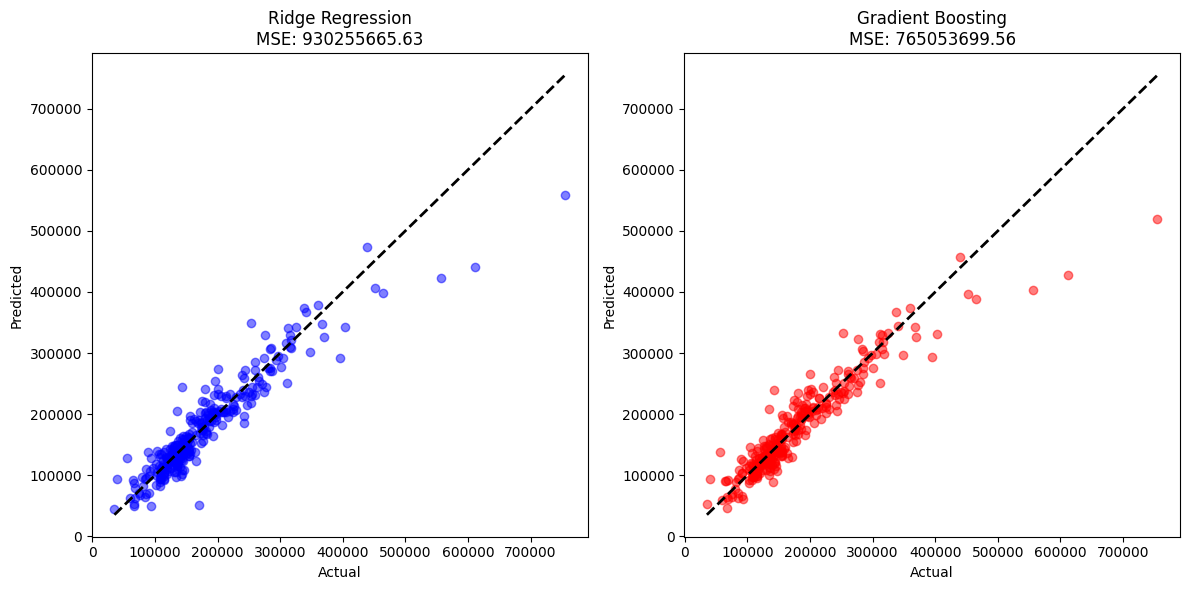

In [153]:

ridge_mse = model_performance_df.loc['Ridge', 'MSE']
gb_mse = non_linear_performance_df.loc['Gradient Boosting','MSE_nl']


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot Ridge Regression predicted value vs actual value
axs[0].scatter(y_test, ridge_predictions, color='blue', alpha=0.5)
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # 绘制45度线
axs[0].set_title(f'Ridge Regression\nMSE: {ridge_mse:.2f}')
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('Predicted')

# plot Gradient Boosting predicted value vs actual value
axs[1].scatter(y_test, gb_predictions, color='red', alpha=0.5)
axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # 绘制45度线
axs[1].set_title(f'Gradient Boosting\nMSE: {gb_mse:.2f}')
axs[1].set_xlabel('Actual')
axs[1].set_ylabel('Predicted')


plt.tight_layout()
plt.show()


# Check Feature Importance with Three Methods for non-linear model Gradient Boosting model


### Individual Conditional Expectation(ICE) Plot

In [154]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

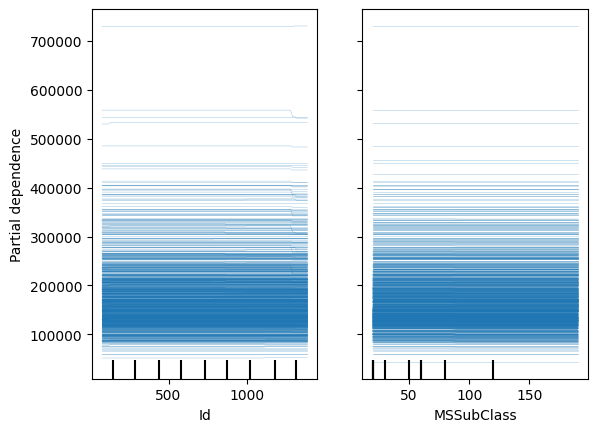

In [155]:
# plot ICE

model_gb = non_linear_models['Gradient Boosting']
features = [0, 1] 
PartialDependenceDisplay.from_estimator(model_gb, X_train, features, kind='individual', feature_names=feature_names)
plt.show()

In [156]:
from sklearn.inspection import permutation_importance

### Permutation method to check Gradient Boosting Tree model's feature importance

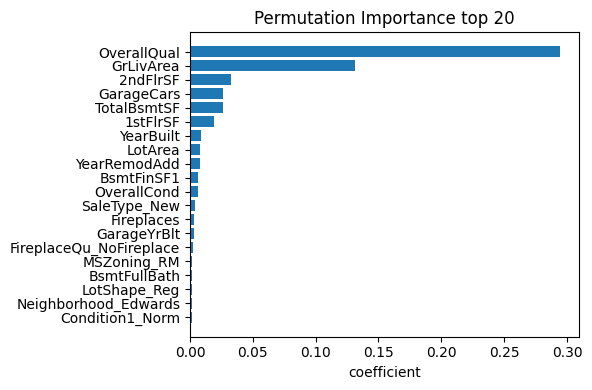

In [157]:
result = permutation_importance(model_gb, X_test, y_test, n_repeats=10, random_state=42)
sorted_index = result.importances_mean.argsort()[-20:]

# plot
plt.figure(figsize=(6, len(sorted_index) * 0.2))
plt.barh(range(len(sorted_index)), result.importances_mean[sorted_index], align='center')
plt.yticks(range(len(sorted_index)), [feature_names[i] for i in sorted_index])
plt.xlabel('coefficient')
plt.title('Permutation Importance top 20')
plt.tight_layout()
plt.show()

### Decision tree method to check Gradient Boosting Tree model's feature importance

In [158]:
dt_model = non_linear_models['Gradient Boosting']
importance = dt_model.feature_importances_

feature_importances = pd.DataFrame(zip(feature_names, importance), columns=['Feature','Importance'])
feature_importances_sorted = feature_importances.sort_values(by= 'Importance', ascending=True).tail(20)
feature_importances_sorted

,Feature,Importance
215,GarageType_Attchd,0.003278
212,FireplaceQu_NoFireplace,0.004378
63,Neighborhood_Edwards,0.004461
29,OpenPorchSF,0.004625
196,CentralAir_Y,0.004706
32,ScreenPorch,0.005401
25,GarageYrBlt,0.006952
24,Fireplaces,0.007314
5,OverallCond,0.007441
7,YearRemodAdd,0.010697


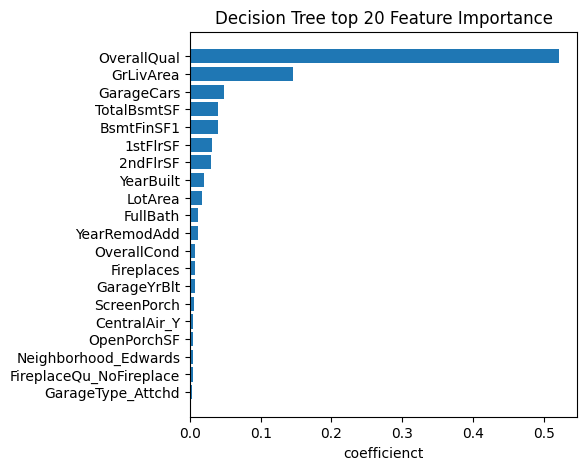

In [159]:
# plot 

plt.figure(figsize=(5,5))
plt.barh(feature_importances_sorted['Feature'],feature_importances_sorted['Importance'],align='center')
plt.title('Decision Tree top 20 Feature Importance')
plt.xlabel('coefficienct')
plt.tight_layout
plt.show()

### Shaply to check Gradient Boosting Tree model's feature importance

In [160]:
pip install shap

In [161]:
import shap

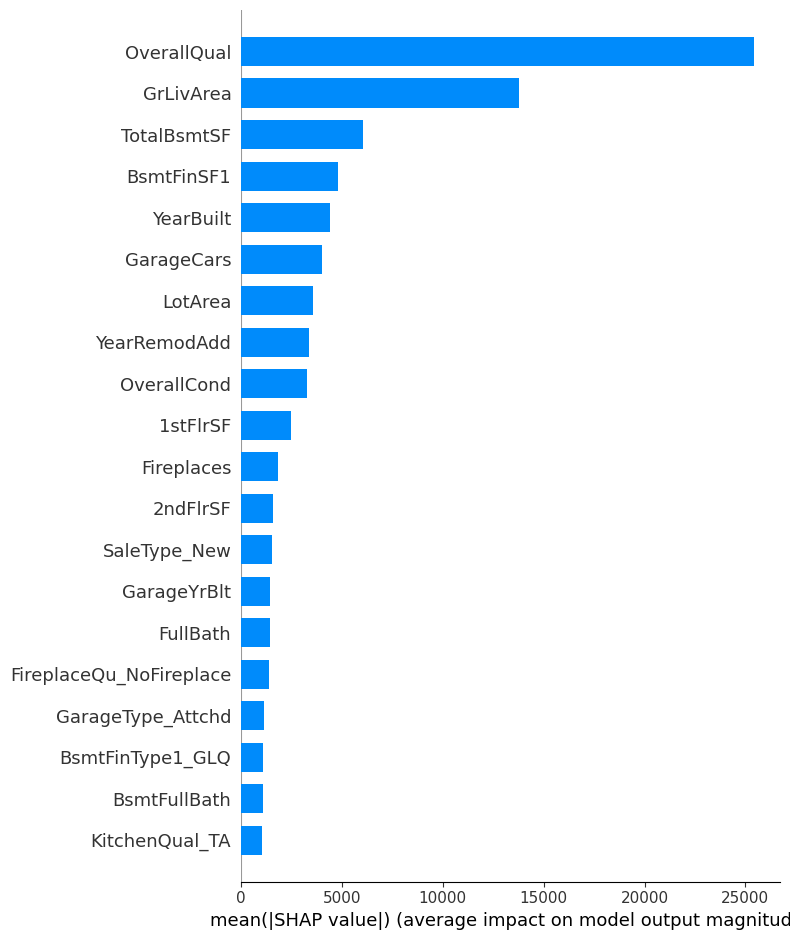

In [162]:
explainer = shap.TreeExplainer(model_gb)
shap_values = explainer.shap_values(X_train)
shap_values
# plot
shap.summary_plot(shap_values, X_train, plot_type='bar')



# A table with feature rankings (most to least important features) for both models shown side-by-side

In [163]:
gb_model = non_linear_models['Gradient Boosting']
ridge_model = models['Linear Regression']



# get Ridge model's feature importance using absolute value
ridge_importance = abs(ridge_model.coef_)

# get Gradient Boosting  model's feature importance using absolute value
gb_importance = gb_model.feature_importances_

# convert to DataFrame
ridge_df = pd.DataFrame({'Feature': feature_names, 'Ridge Importance': ridge_importance})
gb_df = pd.DataFrame({'Feature': feature_names, 'GB Importance': gb_importance})

# sort two dataframe
ridge_df = ridge_df.sort_values(by='Ridge Importance', ascending=False).reset_index(drop=True)
gb_df = gb_df.sort_values(by='GB Importance', ascending=False).reset_index(drop=True)

# concat two dataset
feature_importance_df = pd.concat([ridge_df, gb_df], axis=1)

# Most 20 important features for both models
feature_importance_df.head(20)





,Feature,Ridge Importance,Feature,GB Importance
0,PoolQC_NoPool,3.281818e+06,OverallQual,0.521597
1,PoolQC_Gd,1.348424e+06,GrLivArea,0.145543
2,RoofMatl_Tar&Grv,9.574367e+05,GarageCars,0.048362
3,RoofMatl_Roll,9.567346e+05,TotalBsmtSF,0.040229
4,RoofMatl_WdShake,9.561776e+05,BsmtFinSF1,0.039411
5,RoofMatl_CompShg,9.537837e+05,1stFlrSF,0.031767
6,RoofMatl_WdShngl,9.465720e+05,2ndFlrSF,0.029830
7,RoofMatl_Metal,9.111058e+05,YearBuilt,0.019647
8,PoolQC_Fa,8.044356e+05,LotArea,0.017168
9,MiscFeature_TenC,7.884762e+05,FullBath,0.011355


In [164]:
import pandas as pd

# Get Ridge model's feature importance with sign
ridge_importance_with_sign = ridge_model.coef_

# Convert to DataFrame
ridge_df = pd.DataFrame({
    'Feature': feature_names,
    'Ridge Importance': ridge_importance_with_sign,
    'Absolute Ridge Importance': abs(ridge_importance_with_sign)
})

# Sort by absolute value but keep the sign
ridge_df_sorted = ridge_df.sort_values(by='Absolute Ridge Importance', ascending=False).reset_index(drop=True)

# Get Gradient Boosting model's feature importance
gb_importance = gb_model.feature_importances_

# Convert to DataFrame and sort
gb_df_sorted = pd.DataFrame({
    'Feature': feature_names,
    'GB Importance': gb_importance
}).sort_values(by='GB Importance', ascending=False).reset_index(drop=True)

# Combine the top 20 most important features from both models into one DataFrame
top_features_df = pd.concat([
    ridge_df_sorted.drop(columns=['Absolute Ridge Importance']),
    (gb_df_sorted)], axis=1)

# Now top_features_df will show the top 20 features for both models, including the sign for the Ridge model
print(top_features_df.head(20))

             Feature  Ridge Importance                  Feature  GB Importance
0      PoolQC_NoPool      3.281818e+06              OverallQual       0.521597
1          PoolQC_Gd     -1.348424e+06                GrLivArea       0.145543
2   RoofMatl_Tar&Grv     -9.574367e+05               GarageCars       0.048362
3      RoofMatl_Roll     -9.567346e+05              TotalBsmtSF       0.040229
4   RoofMatl_WdShake     -9.561776e+05               BsmtFinSF1       0.039411
5   RoofMatl_CompShg     -9.537837e+05                 1stFlrSF       0.031767
6   RoofMatl_WdShngl     -9.465720e+05                 2ndFlrSF       0.029830
7     RoofMatl_Metal     -9.111058e+05                YearBuilt       0.019647
8          PoolQC_Fa     -8.044356e+05                  LotArea       0.017168
9   MiscFeature_TenC      7.884762e+05                 FullBath       0.011355
10   Condition2_PosN     -2.353313e+05             YearRemodAdd       0.010697
11     GarageQual_Po     -1.712479e+05              

In [165]:
print(top_features_df.tail(20))

              Feature  Ridge Importance                Feature  GB Importance
240        GarageArea      3.321462e+01    Neighborhood_Timber            0.0
241         GrLivArea      3.318212e+01        Condition1_PosA            0.0
242        MasVnrArea      2.514708e+01    Exterior2nd_Wd Shng            0.0
243       TotalBsmtSF      2.344494e+01        Condition1_RRAn            0.0
244          2ndFlrSF      2.248490e+01        Condition2_PosN            0.0
245       LotFrontage      1.896543e+01        Condition2_PosA            0.0
246        WoodDeckSF      1.719149e+01       MasVnrType_Stone            0.0
247        MSSubClass      1.716665e+01           ExterQual_Fa            0.0
248        BsmtFinSF1      1.672341e+01           ExterQual_Gd            0.0
249     EnclosedPorch      1.412415e+01           ExterQual_TA            0.0
250        BsmtFinSF2      6.232341e+00        Condition2_Norm            0.0
251      LowQualFinSF      6.214860e+00           ExterCond_Gd  

# ICE plots for the two most important features for both models.


In [166]:
from sklearn.inspection import PartialDependenceDisplay

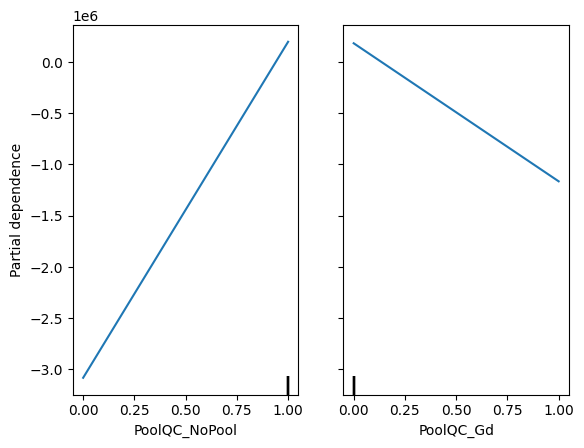

In [167]:
# Ridge model

ridge_feature1_name = ridge_df_sorted['Feature'][0]
ridge_feature2_name = ridge_df_sorted['Feature'][1]
PartialDependenceDisplay.from_estimator(ridge_model, X_train, features=[ridge_feature1_name,ridge_feature2_name], grid_resolution=20)

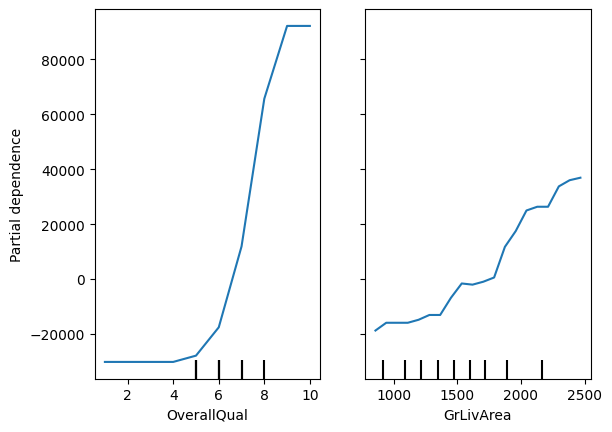

In [168]:
# Gradient Boosting model


gb_feature1_name = gb_df_sorted['Feature'][0]
gb_feature2_name = gb_df_sorted['Feature'][1]
PartialDependenceDisplay.from_estimator(gb_model, X_train, features=[gb_feature1_name,gb_feature2_name], grid_resolution=20)

#  Interactions. Are there any interacting features? (Use Shapley values to investigate.) If yes, then describe the interactions.


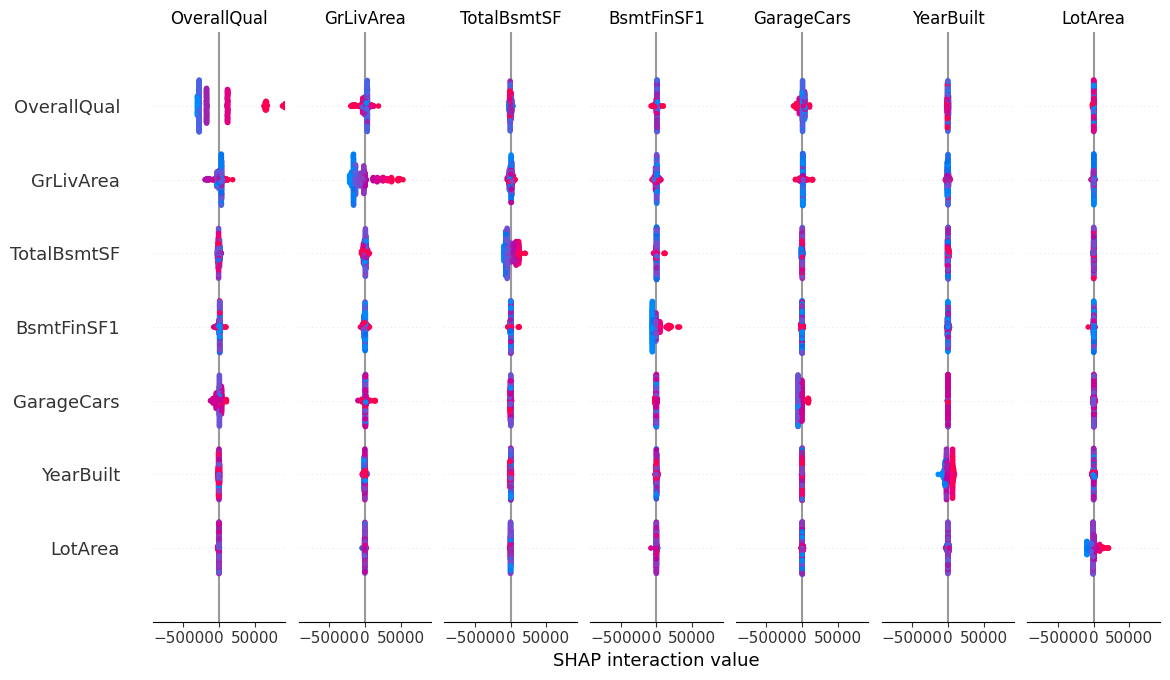

In [169]:
import shap

# Create a SHAP explainer object for your model
explainer = shap.Explainer(model)

# Calculate SHAP values for your test data
shap_values = explainer(X_test)

# Calculate SHAP interaction values
shap_interaction_values = explainer.shap_interaction_values(X_test)

# Summarize the interaction values
shap.summary_plot(shap_interaction_values, X_test)
